In [1]:
#import the necessary modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline

In [2]:
def score(target, predictions):
    return rmse(np.log(target), np.log(predictions))

In [3]:
#print the columns with missing values and number of them

def missing_values(data):
    col_missing = 0
    
    print('COLUMNS WITH MISSING VALUES: \n')

    for col in data.columns: #check each column of the training dataset
        if data[col].isnull().sum() != 0: #if there are missing values in that column
            print(f'{col}, {data[col].isnull().sum()}') #print the column name a                                                                         number of missing values
            col_missing += 1

    if col_missing == 0:
        print('There are no columns with missing values!')

In [4]:
#some columns with missing values need to be fixed, because Nan indicates lack of a service instead of lack of the data

def fix_missing_values(data):
    data['Alley'].fillna('NoAlleyAccess', inplace = True)

    data['BsmtQual'].fillna('NoBasement', inplace = True)
    data['BsmtCond'].fillna('NoBasement', inplace = True)
    data['BsmtExposure'].fillna('NoBasement', inplace = True)
    data['BsmtFinType1'].fillna('NoBasement', inplace = True)
    data['BsmtFinType2'].fillna('NoBasement', inplace = True)

    data['FireplaceQu'].fillna('NoFireplace', inplace = True)

    data['GarageType'].fillna('NoGarage', inplace = True)
    data['GarageFinish'].fillna('NoGarage', inplace = True)
    data['GarageQual'].fillna('NoGarage', inplace = True)
    data['GarageCond'].fillna('NoGarage', inplace = True)

    data['PoolQC'].fillna('NoPool', inplace = True)

    data['Fence'].fillna('NoFence', inplace = True)

    data['MiscFeature'].fillna('None', inplace = True)

In [5]:
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

# Load the data

In [6]:
#load the training and testing datasets
training_data = pd.read_csv('train.csv')
testing_data = pd.read_csv('test.csv')

In [7]:
print(training_data.shape)
print(testing_data.shape)
#print(data_merged.shape)

(1460, 81)
(1459, 80)


In [8]:
training_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Outliers

&lt;matplotlib.axes._subplots.AxesSubplot at 0x122ff10a0&gt;

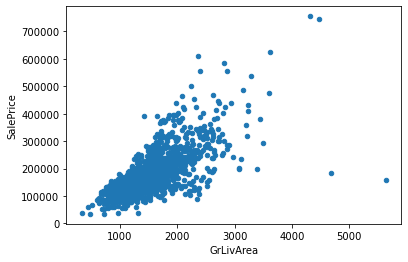

In [9]:
training_data.plot.scatter(x = 'GrLivArea', y = 'SalePrice')

In [10]:
#Remove data with big 'GrLivArea' and small 'SalePrice'
training_data.drop(training_data[(training_data['GrLivArea'] > 4000) & (training_data['SalePrice'] < 400000)].index, inplace = True)

&lt;matplotlib.axes._subplots.AxesSubplot at 0x10e00d850&gt;

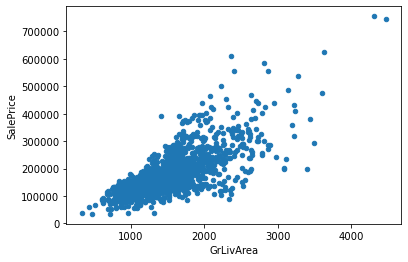

In [11]:
training_data.plot.scatter(x = 'GrLivArea', y = 'SalePrice')

# Distribution of target variable

&lt;matplotlib.axes._subplots.AxesSubplot at 0x1234a7700&gt;

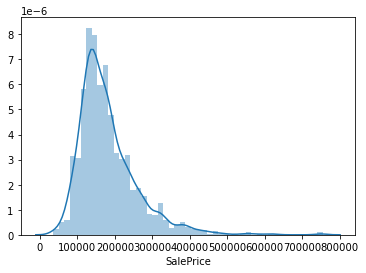

In [12]:
sns.distplot(training_data['SalePrice'])

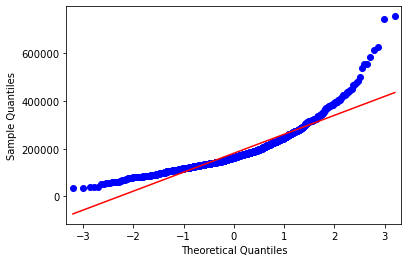

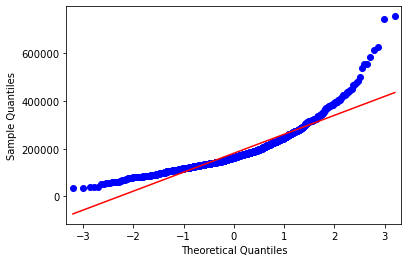

In [13]:
sm.qqplot(training_data['SalePrice'], line = 's')

&lt;matplotlib.axes._subplots.AxesSubplot at 0x123558c70&gt;

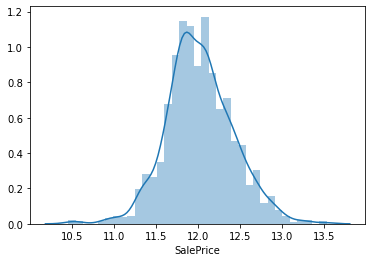

In [14]:
# Transform the target variable
sns.distplot(np.log(training_data['SalePrice']))

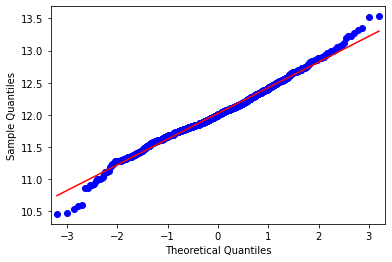

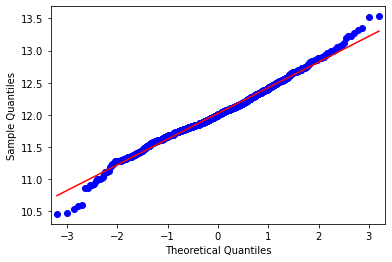

In [15]:
sm.qqplot(np.log(training_data['SalePrice']), line = 's')

In [16]:
# The log of the target variable is "more" normally distributed, so we transform it
training_data['SalePrice'] = np.log(training_data['SalePrice'])

# Treat the missing values

In [17]:
#check for missing values
print('TRAINING DATASET')
missing_values(training_data)

print('\n\n')

print('TESTING DATASET')
missing_values(testing_data)

TRAINING DATASET
COLUMNS WITH MISSING VALUES: 

LotFrontage, 259
Alley, 1367
MasVnrType, 8
MasVnrArea, 8
BsmtQual, 37
BsmtCond, 37
BsmtExposure, 38
BsmtFinType1, 37
BsmtFinType2, 38
Electrical, 1
FireplaceQu, 690
GarageType, 81
GarageYrBlt, 81
GarageFinish, 81
GarageQual, 81
GarageCond, 81
PoolQC, 1452
Fence, 1177
MiscFeature, 1404



TESTING DATASET
COLUMNS WITH MISSING VALUES: 

MSZoning, 4
LotFrontage, 227
Alley, 1352
Utilities, 2
Exterior1st, 1
Exterior2nd, 1
MasVnrType, 16
MasVnrArea, 15
BsmtQual, 44
BsmtCond, 45
BsmtExposure, 44
BsmtFinType1, 42
BsmtFinSF1, 1
BsmtFinType2, 42
BsmtFinSF2, 1
BsmtUnfSF, 1
TotalBsmtSF, 1
BsmtFullBath, 2
BsmtHalfBath, 2
KitchenQual, 1
Functional, 2
FireplaceQu, 730
GarageType, 76
GarageYrBlt, 78
GarageFinish, 78
GarageCars, 1
GarageArea, 1
GarageQual, 78
GarageCond, 78
PoolQC, 1456
Fence, 1169
MiscFeature, 1408
SaleType, 1


In [18]:
#fix the missing values that indicate a lack of feature and not a data not available
fix_missing_values(training_data)
fix_missing_values(testing_data)

#check for missing values
print('TRAINING DATASET')
missing_values(training_data)

print('\n\n')

print('TESTING DATASET')
missing_values(testing_data)

TRAINING DATASET
COLUMNS WITH MISSING VALUES: 

LotFrontage, 259
MasVnrType, 8
MasVnrArea, 8
Electrical, 1
GarageYrBlt, 81



TESTING DATASET
COLUMNS WITH MISSING VALUES: 

MSZoning, 4
LotFrontage, 227
Utilities, 2
Exterior1st, 1
Exterior2nd, 1
MasVnrType, 16
MasVnrArea, 15
BsmtFinSF1, 1
BsmtFinSF2, 1
BsmtUnfSF, 1
TotalBsmtSF, 1
BsmtFullBath, 2
BsmtHalfBath, 2
KitchenQual, 1
Functional, 2
GarageYrBlt, 78
GarageCars, 1
GarageArea, 1
SaleType, 1


&lt;matplotlib.axes._subplots.AxesSubplot at 0x120c2b550&gt;

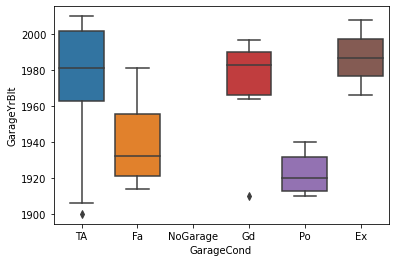

In [19]:
#Garage built more in the past are in worse condition
sns.boxplot(training_data['GarageCond'], training_data['GarageYrBlt'])

In [20]:
#remove 'GarageYrBlt' column, because if there is no garage no built year is available. In addition, we use the fact that a newer garage is reflected in a better condition. 
if 'GarageYrBlt' in training_data.columns:
    training_data.drop(columns = 'GarageYrBlt', inplace = True)
else:
    print('\'GarageYrBlt\' column already removed in training dataset')

# if 'GarageYrBlt' in testing_data.columns:
#     testing_data.drop(columns = 'GarageYrBlt', inplace = True)
# else:
#     print('\'GarageYrBlt\' column already removed in testing dataset')

In [591]:
training_data.corrwith(training_data['LotFrontage']).sort_values(ascending = False)[0:5]

LotFrontage    1.000000
1stFlrSF       0.457181
LotArea        0.426095
GrLivArea      0.402797
TotalBsmtSF    0.392075
dtype: float64

Parameters: const          13.830070
LotAreaSqrt     0.582289
dtype: float64
R2: 0.36240666902481333


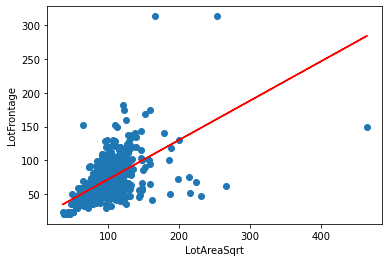

In [592]:
#linear regression between 'LotAreaSqrt' and 'LotFrontage'
training_data['LotAreaSqrt'] = np.sqrt(training_data['LotArea'])
X_lf = sm.add_constant(training_data[training_data['LotFrontage'].notnull()]['LotAreaSqrt'])
y_lf = training_data['LotFrontage'].dropna()
model_lf = sm.OLS(y_lf, X_lf)
results_lf = model_lf.fit()
#print(results_lf.summary())

print(f'Parameters: {results_lf.params}')
print(f'R2: {results_lf.rsquared}')

#plot the results of the linear regression
plt.scatter(training_data['LotAreaSqrt'], training_data['LotFrontage'])
plt.plot(training_data['LotAreaSqrt'], results_lf.params[0] + results_lf.params[1] * training_data['LotAreaSqrt'], '-r')
plt.xlabel('LotAreaSqrt')
plt.ylabel('LotFrontage')

training_data.drop(columns = 'LotAreaSqrt', inplace = True)

In [593]:
training_data.corrwith(training_data['LotFrontage']).sort_values(ascending = False)[0:5]

#'LotFrontage' and 'LotAreaSqrt' are correlated, so I can use this relationship to replace the missing values in 'LotFrontage'

LotFrontage    1.000000
1stFlrSF       0.457181
LotArea        0.426095
GrLivArea      0.402797
TotalBsmtSF    0.392075
dtype: float64

In [594]:
#Replace missing values of 'LotFrontage' with square root of 'LotArea' (see linear regression above)
training_data['LotFrontage'].fillna(results_lf.params[0] + results_lf.params[1] * np.sqrt(training_data['LotArea']), inplace = True)

testing_data['LotFrontage'].fillna(results_lf.params[0] + results_lf.params[1] * np.sqrt(testing_data['LotArea']), inplace = True)

In [595]:
#check for missing values
print('TRAINING DATASET')
missing_values(training_data)

print('\n\n')

print('TESTING DATASET')
missing_values(testing_data)

TRAINING DATASET
COLUMNS WITH MISSING VALUES: 

MasVnrType, 8
MasVnrArea, 8
Electrical, 1



TESTING DATASET
COLUMNS WITH MISSING VALUES: 

MSZoning, 4
Utilities, 2
Exterior1st, 1
Exterior2nd, 1
MasVnrType, 16
MasVnrArea, 15
BsmtFinSF1, 1
BsmtFinSF2, 1
BsmtUnfSF, 1
TotalBsmtSF, 1
BsmtFullBath, 2
BsmtHalfBath, 2
KitchenQual, 1
Functional, 2
GarageCars, 1
GarageArea, 1
SaleType, 1


In [596]:
training_data.shape

(1460, 80)

In [597]:
#Replace the rows with the remaining missing values
training_data.fillna(method = 'ffill', inplace = True)
testing_data.fillna(method = 'ffill', inplace = True)

#training_data.reset_index(drop = True, inplace = True)
#testing_data.reset_index(drop = True, inplace = True)

print(f'Dimensions training dataset: {training_data.shape}')
print(f'Dimensions testing dataset: {testing_data.shape}')

Dimensions training dataset: (1460, 80)
Dimensions testing dataset: (1459, 79)


In [598]:
#check for missing values
print('TRAINING DATASET')
missing_values(training_data)

print('\n\n')

print('TESTING DATASET')
missing_values(testing_data)

TRAINING DATASET
COLUMNS WITH MISSING VALUES: 

There are no columns with missing values!



TESTING DATASET
COLUMNS WITH MISSING VALUES: 

There are no columns with missing values!


# One-hot encoding of categorical variables

In [599]:
from sklearn.preprocessing import OneHotEncoder

#find categorical features
categorical_cols = training_data.columns[training_data.dtypes == 'object']
# creating one hot encoder object 
encoder = OneHotEncoder(drop = 'first')
#encode the categorical variable
X = encoder.fit_transform(training_data[categorical_cols])
#To add this back into the original dataframe 
df_encoded = pd.DataFrame(X.toarray(), columns = encoder.get_feature_names(categorical_cols))
#Concatenate training_data with encoded dataframe
training_data_encoded = pd.concat([training_data, df_encoded], axis=1)
#Drop the original categorical columns because they are encoded now
training_data_encoded.drop(columns = categorical_cols, inplace = True) 

#Encode the categorical features in the testing dataset
X = encoder.transform(testing_data[categorical_cols])
#To add this back into the original dataframe 
df_encoded = pd.DataFrame(X.toarray(), columns = encoder.get_feature_names(categorical_cols))
#Concatenate training_data with encoded dataframe
testing_data_encoded = pd.concat([testing_data, df_encoded], axis=1)
#Drop the original categorical columns because they are encoded now
testing_data_encoded.drop(columns = categorical_cols, inplace = True) 

# Correlations and Linear Regression

In [600]:
#Target variable
target = training_data_encoded['SalePrice']
#Features
X_training = training_data_encoded.drop(columns = 'SalePrice')

#correlation between target and features
main_corr = X_training.corrwith(target).sort_values(ascending = False)[0:20]
main_features = main_corr.index

In [601]:
main_features

Index([&#39;OverallQual&#39;, &#39;GrLivArea&#39;, &#39;GarageCars&#39;, &#39;GarageArea&#39;, &#39;TotalBsmtSF&#39;,
       &#39;1stFlrSF&#39;, &#39;FullBath&#39;, &#39;TotRmsAbvGrd&#39;, &#39;YearBuilt&#39;, &#39;YearRemodAdd&#39;,
       &#39;Foundation_PConc&#39;, &#39;MasVnrArea&#39;, &#39;Fireplaces&#39;, &#39;ExterQual_Gd&#39;,
       &#39;BsmtFinType1_GLQ&#39;, &#39;Neighborhood_NridgHt&#39;, &#39;BsmtFinSF1&#39;,
       &#39;SaleType_New&#39;, &#39;SaleCondition_Partial&#39;, &#39;LotFrontage&#39;],
      dtype=&#39;object&#39;)

In [602]:
main_corr

OverallQual              0.790982
GrLivArea                0.708624
GarageCars               0.640409
GarageArea               0.623431
TotalBsmtSF              0.613581
1stFlrSF                 0.605852
FullBath                 0.560664
TotRmsAbvGrd             0.533723
YearBuilt                0.522897
YearRemodAdd             0.507101
Foundation_PConc         0.497734
MasVnrArea               0.474526
Fireplaces               0.466929
ExterQual_Gd             0.452466
BsmtFinType1_GLQ         0.434597
Neighborhood_NridgHt     0.402149
BsmtFinSF1               0.386420
SaleType_New             0.357509
SaleCondition_Partial    0.352060
LotFrontage              0.340937
dtype: float64

In [603]:
features_and_target = pd.concat([training_data_encoded[main_features], target], axis = 1)
#sns.pairplot(features_and_target)

&lt;matplotlib.axes._subplots.AxesSubplot at 0x136185a90&gt;

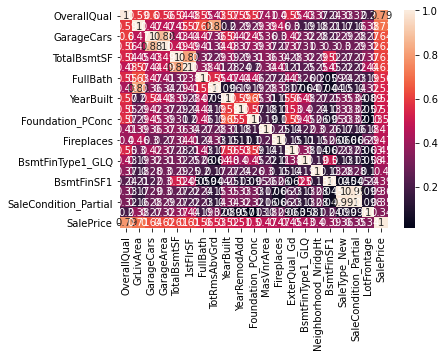

In [604]:
sns.heatmap(features_and_target.corr(), annot = True)

In [605]:
calc_vif(X_training[main_features])

,variables,VIF
0,OverallQual,63.906068
1,GrLivArea,52.509227
2,GarageCars,35.256711
3,GarageArea,30.627775
4,TotalBsmtSF,27.355844
5,1stFlrSF,39.472204
6,FullBath,19.778575
7,TotRmsAbvGrd,60.877467
8,YearBuilt,8768.698435
9,YearRemodAdd,8690.678971


In [606]:
vif = calc_vif(X_training[main_features].drop(columns = ['YearBuilt', 'OverallQual', 'TotRmsAbvGrd', 'SaleCondition_Partial', 'GarageCars', '1stFlrSF', 'GrLivArea', 'YearRemodAdd', 'TotalBsmtSF', 'FullBath', 'GarageArea']))
vif

,variables,VIF
0,Foundation_PConc,3.174554
1,MasVnrArea,1.621361
2,Fireplaces,2.282952
3,ExterQual_Gd,2.419358
4,BsmtFinType1_GLQ,2.512284
5,Neighborhood_NridgHt,1.269376
6,BsmtFinSF1,3.024444
7,SaleType_New,1.297579
8,LotFrontage,3.286345


In [629]:
features = ['Foundation_PConc', 'MasVnrArea', 'Fireplaces', 'ExterQual_Gd', 'BsmtFinType1_GLQ', 'Neighborhood_NridgHt', 'BsmtFinSF1', 'SaleType_New', 'LotFrontage']
X_training_new = X_training[features]
X_training_new.head()

,Foundation_PConc,MasVnrArea,Fireplaces,ExterQual_Gd,BsmtFinType1_GLQ,Neighborhood_NridgHt,BsmtFinSF1,SaleType_New,LotFrontage
0,1.0,196.0,0,1.0,1.0,0.0,706,0.0,65.0
1,0.0,0.0,1,0.0,0.0,0.0,978,0.0,80.0
2,1.0,162.0,1,1.0,1.0,0.0,486,0.0,68.0
3,0.0,0.0,1,0.0,0.0,0.0,216,0.0,60.0
4,1.0,350.0,1,1.0,1.0,0.0,655,0.0,84.0


In [630]:
X_training_new.corrwith(target).sort_values(ascending = False)

Foundation_PConc        0.497734
MasVnrArea              0.474526
Fireplaces              0.466929
ExterQual_Gd            0.452466
BsmtFinType1_GLQ        0.434597
Neighborhood_NridgHt    0.402149
BsmtFinSF1              0.386420
SaleType_New            0.357509
LotFrontage             0.340937
dtype: float64

In [631]:
X_training_new = sm.add_constant(X_training_new)
model = sm.OLS(target, X_training_new)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     280.5
Date:                Tue, 06 Oct 2020   Prob (F-statistic):          5.93e-310
Time:                        17:25:51   Log-Likelihood:                -17808.
No. Observations:                1460   AIC:                         3.564e+04
Df Residuals:                    1450   BIC:                         3.569e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P&gt;|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 7.221e+

In [636]:
from statsmodels.tools.eval_measures import rmse

rmse(np.log(target), np.log(results.fittedvalues))

0.23357935207604993

Text(0, 0.5, &#39;Predicted Sale Price&#39;)

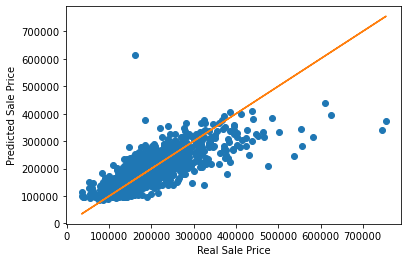

In [632]:
plt.plot(target, results.fittedvalues, 'o')
plt.plot(target, target, '-')
plt.xlabel('Real Sale Price')
plt.ylabel('Predicted Sale Price')

In [621]:
#Features for test dataset
X_testing = testing_data_encoded[features]
X_testing = sm.add_constant(X_testing)

predictions = results.predict(X_testing)

In [613]:
df_predictions = pd.DataFrame(zip(testing_data['Id'], predictions), columns = ['Id', 'SalePrice'])
df_predictions.head()

,Id,SalePrice
0,1461,124013.104331
1,1462,144795.808735
2,1463,207093.729254
3,1464,206537.538767
4,1465,160500.423459


In [614]:
df_predictions.to_csv('my_submission.csv', index = False)

# Decision Tree Regressor

In [637]:
from sklearn.tree import DecisionTreeRegressor

In [647]:
# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=10)
regr_1.fit(X_training, target)

pred_train_1 = regr_1.predict(X_training)

rmse(np.log(target), np.log(pred_train_1))

0.07519638125491684

In [684]:
predictions_tree = regr_1.predict(testing_data_encoded)

df_predictions_tree = pd.DataFrame(zip(testing_data['Id'], predictions_tree), columns = ['Id', 'SalePrice'])

In [651]:
df_predictions_tree.to_csv('my_submission_tree.csv', index = False)

# Gradient Boosting Regressor

In [652]:
from sklearn.ensemble import GradientBoostingRegressor

In [694]:
reg_boosting = GradientBoostingRegressor(random_state = 0, max_depth = 7)
reg_boosting.fit(X_training, target)

pred_train = reg_boosting.predict(X_training)

rmse(np.log(target), np.log(pred_train))

0.01851338246122541

In [695]:
predictions = reg_boosting.predict(testing_data_encoded)

df_predictions = pd.DataFrame(zip(testing_data['Id'], predictions), columns = ['Id', 'SalePrice'])

df_predictions.to_csv('my_submission_grad_boosting.csv', index = False)